<a href="https://colab.research.google.com/github/federicocampo/CNN_prova/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from skimage import img_as_float
from skimage.restoration import denoise_wavelet
from PIL import Image
import pywt
import os
import glob
import numpy as np
import logging
import time

In [9]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro'

I've run the fit on original dataset just for trying

In [10]:
import multiprocessing as mp

def parallel_read_img(image_path):
  fnames = glob.glob(os.path.join(image_path, '*.pgm'))

  pool = mp.Pool(processes=4)
  results = pool.map_async(imread, fnames)

  x = results.get()
  x_np = np.array(x, dtype='float32')[..., np.newaxis]/255

  print('Num images found = ', x_np.shape)
  return x_np


start_time = time.time()

labels = []

image_path = os.path.join(PATH, 'Train/0')
x0_train = parallel_read_img(image_path)
labels += len(x0_train)*[0]

image_path = os.path.join(PATH, 'Train/1')
x1_train = parallel_read_img(image_path)
labels += len(x1_train)*[1]

x_train = np.concatenate((x0_train, x1_train), axis = 0)
y_train = np.array(labels)

print('x_train shape = ', x_train.shape)


labels = []

image_path = os.path.join(PATH, 'Test/0')
x0_test = parallel_read_img(image_path)
labels += len(x0_test)*[0]

image_path = os.path.join(PATH, 'Test/1')
x1_test = parallel_read_img(image_path)
labels += len(x1_test)*[1]

x_test = np.concatenate((x0_test, x1_test), axis = 0)
y_test = np.array(labels)

print('x_test shape = ', x_test.shape)

elapsed_time = time.time() - start_time
logging.info('Elapsed time = %.2f s', elapsed_time)

Num images found =  (209, 60, 60, 1)
Num images found =  (187, 60, 60, 1)
x_train shape =  (396, 60, 60, 1)
Num images found =  (205, 60, 60, 1)
Num images found =  (196, 60, 60, 1)
x_test shape =  (401, 60, 60, 1)


In [ ]:
from keras.layers import Dense, Flatten, BatchNormalization
from keras.models import Sequential

# Defining the model

In [ ]:
model = Sequential([
    Flatten(), 
    Dense(102,  activation = 'relu'), 
    BatchNormalization(),
    Dense(32, activation = 'relu'), 
    BatchNormalization(),

    Dense(1, activation = 'sigmoid')
])

Compile and train

In [ ]:
from keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate = 0.0005),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    x_train, y_train,
    validation_split = 0.25, 
    epochs=50,
)

Epoch 1/50
10/10 [==============================] - 1s 24ms/step - loss: 0.2367 - binary_accuracy: 0.9054 - val_loss: 0.0034 - val_binary_accuracy: 1.0000
Epoch 2/50
10/10 [==============================] - 0s 7ms/step - loss: 0.1739 - binary_accuracy: 0.9533 - val_loss: 0.0263 - val_binary_accuracy: 0.9798
Epoch 3/50
10/10 [==============================] - 0s 9ms/step - loss: 0.1618 - binary_accuracy: 0.9417 - val_loss: 0.0778 - val_binary_accuracy: 0.9596
Epoch 4/50
10/10 [==============================] - 0s 28ms/step - loss: 0.1356 - binary_accuracy: 0.9575 - val_loss: 0.1241 - val_binary_accuracy: 0.9394
Epoch 5/50
10/10 [==============================] - 0s 7ms/step - loss: 0.0958 - binary_accuracy: 0.9839 - val_loss: 0.1297 - val_binary_accuracy: 0.9293
Epoch 6/50
10/10 [==============================] - 0s 8ms/step - loss: 0.2097 - binary_accuracy: 0.9052 - val_loss: 0.5097 - val_binary_accuracy: 0.7879
Epoch 7/50
10/10 [==============================] - 0s 8ms/step - loss: 0.

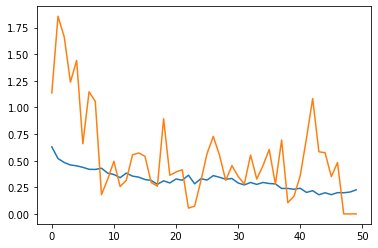

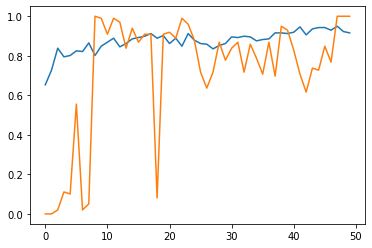

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.show()